#### **Cálculo da declividade**
Cálculo da declividade das comunidade em Florianópolis a partir do MDE do SRTM

Comunidades:
- Morro do 25
- Morro do Mocotó
- Morro da Caixa
- Morro do Horário
- Morro da Mariquinha
- Serrinha

In [27]:
import numpy as np
import geopandas as gpd
import rioxarray
import rasterio
import matplotlib.pyplot as plt
import xarray as xr
from rasterio.enums import Resampling
import contextily as ctx
from rasterstats import zonal_stats

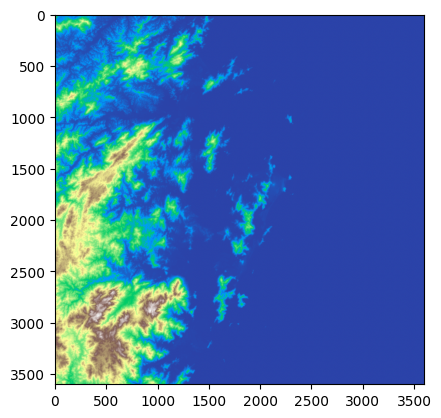

,id,cd_fcu,nm_fcu,cd_uf,nm_uf,sigla_uf,cd_mun,nm_mun,total_pess,total_domi,total_dom0,total_dom1,total_dom_,geometry
0,2,42054070043,Morro do 25,42,Santa Catarina,SC,4205407,Florianópolis,1873,740,740,0,664,"POLYGON ((743207.599 6946577.179, 743187.833 6..."
1,3,42054070070,Sapé,42,Santa Catarina,SC,4205407,Florianópolis,333,178,178,0,125,"POLYGON ((736986.055 6946126.187, 737031.022 6..."
2,4,42054070074,Vila Santa Rosa,42,Santa Catarina,SC,4205407,Florianópolis,484,196,196,0,167,"POLYGON ((743854.192 6947363.112, 743802.225 6..."
3,5,42054070038,Arranha Céu,42,Santa Catarina,SC,4205407,Florianópolis,343,113,113,0,111,"POLYGON ((738467.7 6943921.928, 738360.627 694..."
4,6,42054070061,Vila do Mosquito,42,Santa Catarina,SC,4205407,Florianópolis,273,91,91,0,88,"POLYGON ((754110.15 6960583.482, 754139.711 69..."


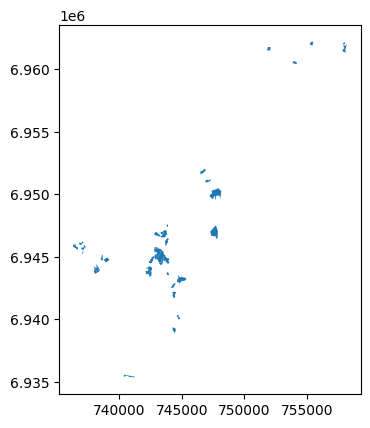

In [2]:
# Lendo os arquivos

srtm_path = r"C:\Users\leti_\OneDrive\Documentos\python_env_app\Trabalho02\s28_w049_1arc_v3.tif"
comunidades_path = r"C:\Users\leti_\OneDrive\Documentos\python_env_app\Trabalho02\comunidades\censo2022_fcu.shp"

comunidades = gpd.read_file(comunidades_path)
srtm = rioxarray.open_rasterio(srtm_path)

with rasterio.open(srtm_path) as src:
    raster = src.read(1)  # lê a primeira banda
    plt.imshow(raster, cmap='terrain')
    plt.show()

comunidades.plot()
comunidades.head()

In [3]:
# Reprojetando o raster de WGS84 PARA SIRGAS 2000 22S
srtm_reprojetado = srtm.rio.reproject("EPSG:31982")
print(srtm_reprojetado.rio.crs)

# Garantindo o mesmo sistema de referências
comunidades = comunidades.to_crs(crs = '31982')
print(comunidades.crs)

# Conferindo limites
print(srtm_reprojetado.rio.bounds())
print(comunidades.total_bounds)

EPSG:31982
EPSG:31982
(696653.628092811, 6899140.038261094, 797735.4703249616, 7012007.469024786)
[ 736309.83685064 6935349.02058402  758204.31865189 6962205.18444636]


In [32]:
# Selecionando as comunidades
print(comunidades["nm_fcu"].unique())

selecionadas = ["Morro do 25", "Morro do Mocotó", "Morro da Caixa", "Morro do Horácio", "Morro da Mariquinha", "Serrinha"]

# Filtrando
comunidades_sel = comunidades[comunidades["nm_fcu"].isin(selecionadas)]
print(comunidades_sel["nm_fcu"].unique())

['Morro do 25' 'Sapé' 'Vila Santa Rosa' 'Arranha Céu' 'Vila do Mosquito'
 'Tapera' 'Caieira do Saco dos Limões' 'Grota' 'Tico-Tico'
 'Morro do Mocotó' 'Morro do Quilombo' 'Chico Mendes' 'Morro da Caixa'
 'Serrinha' 'Comunidade Angra dos Reis' 'Morro do Flamengo'
 'Vila Aparecida' 'Alto da Caieira' 'McLaren' 'Costeira 1'
 'Ocupação Marielle Franco' 'Nova Jerusalém' 'Costeira 2' 'Maloca'
 'Morro do Horácio' 'Boa Vista' 'Morro da Mariquinha' 'Vila Santa Vitória'
 'Papaquara' 'Vila Esperança' 'Monte Cristo'
 'Monsenhor Topp / José Boiteux' 'Nova Esperança' 'Nova Descoberta'
 'Monte Serrat' 'Vila do Arvoredo' 'Jagatá' 'Alto Pantanal' 'Costeira 3'
 'Barreira do Janga' 'Morro do Balão' 'Morro da Queimada' 'Sol Nascente'
 'Rio Tavares - Trevo da Seta' 'Morro da Penitenciária']
['Morro do 25' 'Morro do Mocotó' 'Morro da Caixa' 'Serrinha'
 'Morro do Horácio' 'Morro da Mariquinha']


In [5]:
# Recortando o SRTM pelas comunidades selecionadas
geoms = [geom for geom in comunidades_sel.geometry]

srtm_clip = srtm_reprojetado.rio.clip(
    geoms,
    comunidades_sel.crs,
    drop=True
)

elev0 = srtm_clip.squeeze().values
xres, yres = map(abs, srtm_clip.rio.resolution())

In [35]:
# Melhorando a resolução --> de 30 m para 5 m
srtm_up = srtm_clip.rio.reproject(
    srtm_clip.rio.crs,
    resolution=5.0,
    resampling=Resampling.bilinear
)

elev = srtm_up.squeeze().values
new_transform = srtm_up.rio.transform()
minx, miny, maxx, maxy = srtm_up.rio.bounds()
cell_size = 5.0

In [36]:
# Garantindo a reprojeção do raster
srtm_m = srtm_clip.rio.reproject("EPSG:31982")

# Calculando o gradiente
dzdx, dzdy = np.gradient(srtm_m[0].values, srtm_m.rio.resolution()[0])

# Calculando a declividade em %
slope_percent = np.sqrt(dzdx**2 + dzdy**2) * 100
slope_percent = np.where(np.isfinite(slope_percent), slope_percent, np.nan)

# Deixando o espaço entre as comunidades vazio
mask = rasterio.features.geometry_mask(
    comunidades_sel.geometry,
    transform=srtm_m.rio.transform(),
    invert=True,
    out_shape=srtm_m[0].shape
)

slope_masked = np.where(mask, slope_percent, np.nan)

# Checando os resultados
np.nanmin(slope_masked), np.nanmax(slope_masked)

(np.float64(0.0), np.float64(79874.85008820854))

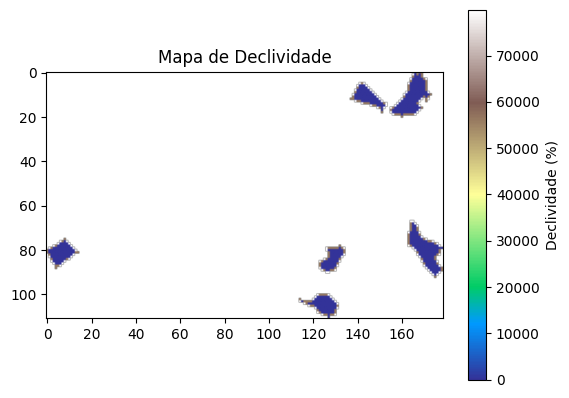

In [51]:
# Plotando o gráfico de teste
plt.imshow(slope_masked, cmap="terrain")
plt.colorbar(label="Declividade (%)")
plt.title("Mapa de Declividade")
plt.savefig(r"C:\Users\Leti_\OneDrive\Documentos\python_env_app\outputs\declividade_teste.png")

In [38]:
# Calculando a declividade com o buffer
buffered = comunidades_sel.buffer(30) # 30 metros - garantindo 1 pixel a mais
srtm_rec = srtm_m.rio.clip(buffered.geometry, comunidades_sel.crs)

# Declividade
res_y, res_x = srtm_rec.rio.resolution() 

dzdy, dzdx = np.gradient(srtm_rec[0].values, res_y, res_x)
slope = np.sqrt(dzdx**2 + dzdy**2) * 100
slope = np.where(np.isfinite(slope), slope, np.nan)

# Recortando novamente o raster
slope_da = xr.DataArray(
    slope,
    coords={"y": srtm_rec.y, "x": srtm_rec.x},
    dims=("y", "x"),
).rio.write_crs(srtm_rec.rio.crs)

slope_final = slope_da.rio.clip(comunidades_sel.geometry, comunidades_sel.crs)

# Checando resultados
np.nanmin(slope_final), np.nanmax(slope_final)

(np.float64(0.0), np.float64(79874.85008821459))

In [20]:
# Inspecionando o valor máximo e sua posição
max_val = np.nanmax(slope)
np.where(slope == max_val)

(array([110]), array([128]))

In [21]:
# Verificar o valor SRTM
y, x = np.where(slope == max_val)
srtm_rec[0].values[y, x]

array([-32767], dtype=int16)

In [48]:
# Calculando novamente a declividade

# Limpando NoData (-32767)
srtm_clean = srtm_clip.where(srtm_clip > 0)

# Calculando a declividade
res_y2, res_x2 = srtm_clean.rio.resolution()
dzdy2, dzdx2 = np.gradient(srtm_clean[0].values, res_y, res_x)

slope2 = np.sqrt(dzdx2**2 + dzdy2**2) * 100
slope2 = np.where(np.isfinite(slope2), slope2, np.nan)

# Criando DataArray 2D
slope_da2 = xr.DataArray(
    slope2,
    coords={"y": srtm_clean.y, "x": srtm_clean.x},
    dims=("y", "x"),
).rio.write_crs(srtm_clean.rio.crs)

# Recortar novamente para o polígono original
slope_final2 = slope_da2.rio.clip(comunidades_sel.geometry, comunidades_sel.crs)

# Conferindo valores
np.nanmin(slope_final2), np.nanmax(slope_final2)

(np.float32(4.847804), np.float32(79.08387))

In [49]:
# Calculando estatísticas básicas

# Salvando o raster temporariamente
temp_slope = "slope_temp.tif"
slope_da2.rio.to_raster(temp_slope)

# Calculando estatísticas por comunidade
stats = zonal_stats(
    comunidades_sel,
    temp_slope,
    stats=["mean", "median", "min", "max"],
    geojson_out=True
)

# Transformando em GeoDataFrame
gdf_stats = gpd.GeoDataFrame.from_features(stats, crs=comunidades_sel.crs)

gdf_stats

,geometry,id,cd_fcu,nm_fcu,cd_uf,nm_uf,sigla_uf,cd_mun,nm_mun,total_pess,total_domi,total_dom0,total_dom1,total_dom_,min,max,mean,median
0,"POLYGON ((743207.599 6946577.179, 743187.833 6...",2,42054070043,Morro do 25,42,Santa Catarina,SC,4205407,Florianópolis,1873,740,740,0,664,7.066829,42.157784,22.071945,19.391216
1,"POLYGON ((742459.949 6943910.904, 742323.112 6...",13,42054070059,Morro do Mocotó,42,Santa Catarina,SC,4205407,Florianópolis,523,186,186,0,161,20.061359,79.083870,34.295002,32.019371
2,"POLYGON ((739042.168 6944628.597, 738997.04 69...",16,42054070049,Morro da Caixa,42,Santa Catarina,SC,4205407,Florianópolis,1125,473,473,0,399,5.141873,52.127987,20.174147,17.894243
3,"POLYGON ((743840.583 6944482.331, 743803.884 6...",17,42054070056,Serrinha,42,Santa Catarina,SC,4205407,Florianópolis,3908,1401,1401,0,1325,6.179762,51.132275,28.784278,28.525942
4,"POLYGON ((743315.353 6946656.157, 743422.698 6...",32,42054070044,Morro do Horácio,42,Santa Catarina,SC,4205407,Florianópolis,2377,972,972,0,823,4.847804,65.040123,25.644113,25.306282
5,"POLYGON ((742666.058 6944673.424, 742586.513 6...",34,42054070040,Morro da Mariquinha,42,Santa Catarina,SC,4205407,Florianópolis,899,368,368,0,318,17.479008,51.447289,36.457714,37.746002


In [40]:
# Gerando uma tabela com as estatíticas básicas
col_id = "nm_fcu"

tabela = gdf_stats[[col_id, "mean", "median", "min", "max"]].rename(columns={
    col_id: "Comunidade",
    "mean": "Média",
    "median": "Mediana",
    "min": "Mínimo",
    "max": "Máximo"
})

# Personalizando
tabela_styled = (
    tabela.style
        .format({
        'Média': '{:.2f}',
        'Mediana': '{:.2f}',
        'Mínimo': '{:.2f}',
        'Máximo': '{:.2f}'
    })
    .set_caption("<div style='text-align:center; font-weight:bold; font-size:18px;'>Estatísticas básicas de declividade</div>")
    .set_table_styles([
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('padding', '8px'), ('background-color', '#f2f2f2')]},
        {'selector': 'th.col0', 'props': [('width', '140px')]},
        {'selector': 'th.col1', 'props': [('width', '100px')]},
        {'selector': 'th.col2', 'props': [('width', '100px')]},
        {'selector': 'th.col3', 'props': [('width', '100px')]},
        {'selector': 'th.col4', 'props': [('width', '100px')]},
    ])
    .hide(axis='index')
)
tabela_styled

Comunidade,Média,Mediana,Mínimo,Máximo
Morro do 25,22.07,19.39,7.07,42.16
Morro do Mocotó,34.30,32.02,20.06,79.08
Morro da Caixa,20.17,17.89,5.14,52.13
Serrinha,28.78,28.53,6.18,51.13
Morro do Horácio,25.64,25.31,4.85,65.04
Morro da Mariquinha,36.46,37.75,17.48,51.45


In [41]:
# Reprojetando a imagem de satélite para plotar o gráfico
import pyproj
from shapely.geometry import box
from shapely.ops import transform

# Criando polígono em EPSG:31982
poly_31982 = box(minx, miny, maxx, maxy)

# Reprojetar o polígono para EPSG:3857 (WebMercator)
project_to_3857 = pyproj.Transformer.from_crs(31982, 3857, always_xy=True).transform
poly_3857 = transform(project_to_3857, poly_31982)

# Extrair polígono reprojetado
minx3857, miny3857, maxx3857, maxy3857 = poly_3857.bounds

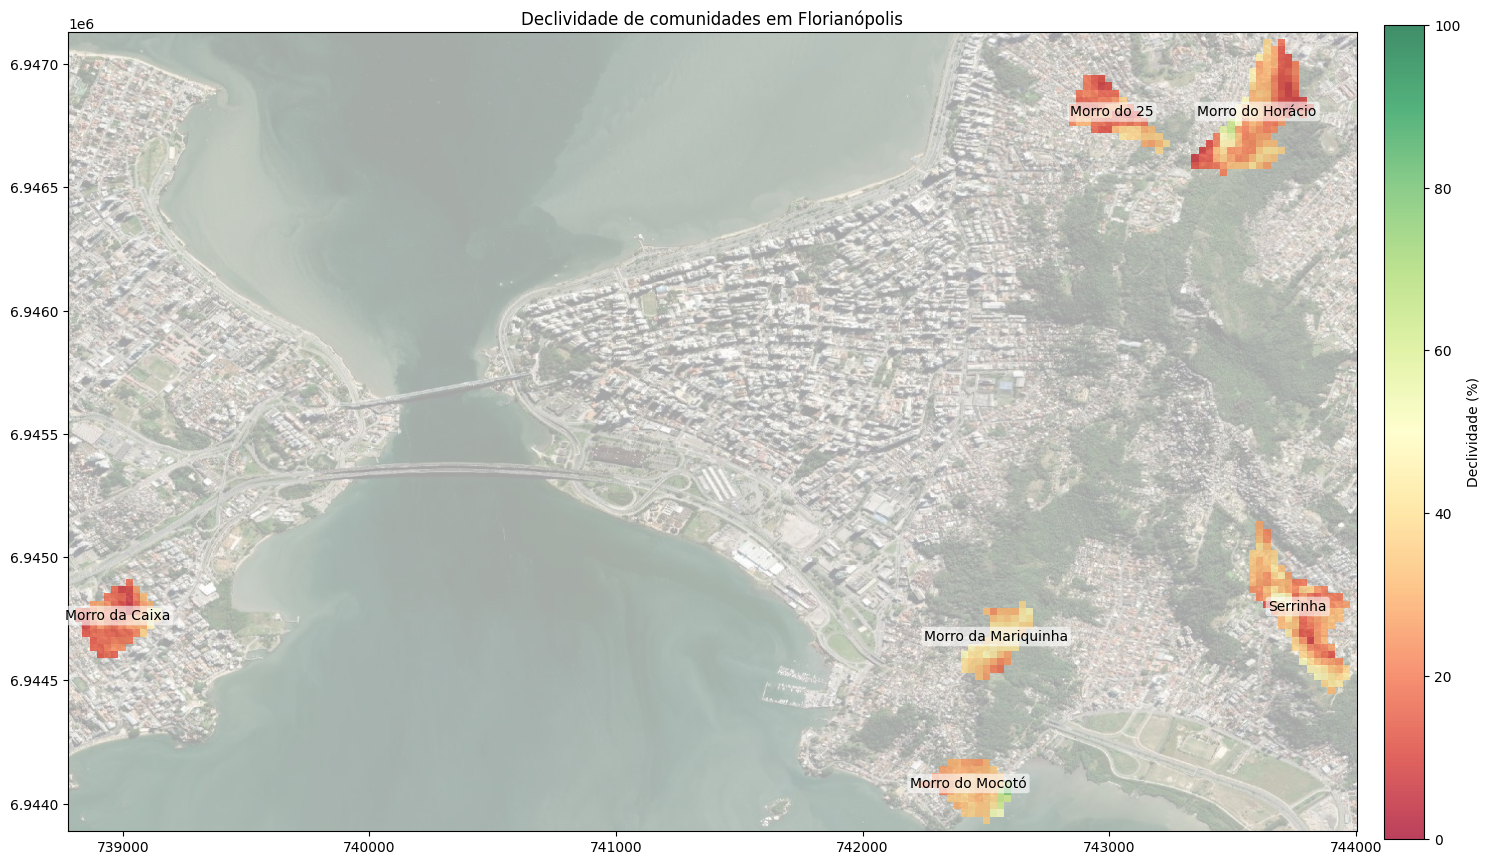

In [50]:
# Gerando mapa
fig, ax = plt.subplots(figsize=(15,15))

basemap_img, extent = ctx.bounds2img(
    minx3857, miny3857, maxx3857, maxy3857,
    zoom=15,
    source=ctx.providers.Esri.WorldImagery
)

# Imagem de satélite
ax.imshow(basemap_img, extent=(minx, maxx, miny, maxy), origin="upper", alpha=0.35)

# Resultados da declividade
im = ax.imshow(
    slope_final2,
    extent=(minx, maxx, miny, maxy),
    origin="upper",
    cmap="RdYlGn",
    alpha=0.75,
    vmin=0,
    vmax=100
)

# Colocando o nome das comunidades
for idx, row in comunidades_sel.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    nome = row["nm_fcu"]

    ax.text(
        x, y,
        nome,
        fontsize=10,
        color="black",
        ha="center",
        #va="center",
        bbox=dict(
            facecolor="white",
            edgecolor="none",
            alpha=0.6,
            boxstyle="round,pad=0.2"
        )
    )


cbar = plt.colorbar(im, ax=ax, label="Declividade (%)", fraction=0.03, pad=0.02)
ax.set_title("Declividade de comunidades em Florianópolis")
plt.tight_layout()
plt.savefig(r"C:\Users\Leti_\OneDrive\Documentos\python_env_app\outputs\declividade.png")
plt.show()